# Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import config
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
import warnings
from matplotlib import rc

# Set constants

In [2]:
# set figure details
dpi = 200

# set colors
healthy_color = "steelblue"
nonhealthy_color = 'orange'
healthy_both_color = 'darkviolet'
nonhealthy_both_color = 'green'

# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)
rc("svg", fonttype="none") 

# Load data

In [3]:
X = pd.read_csv(os.path.join(config.CLEAN_DIR, "taxonomic_features.csv"), index_col=[0, 1])
y = pd.read_csv(os.path.join(config.CLEAN_DIR, "metadata.csv"), index_col=[0, 1]).iloc[:, [0]]
phenotype = pd.read_csv(os.path.join(config.CLEAN_DIR, "metadata.csv"), index_col=[0, 1]).iloc[:, [1]]
GMHI2_scores_ISV = pd.read_csv(os.path.join(config.LOG_DIR, "GMHI2_scores_ISV.csv"), index_col=[0, 1])
display(X.head())
display(y.head())
display(GMHI2_scores_ISV.head())

k__Archaea  k__Archaea|p__Euryarchaeota  \
Study_ID Sample Accession                                            
GMHI-10  SAMN03283239        0.000000                     0.000000   
         SAMN03283266        0.000000                     0.000000   
         SAMN03283281        0.009764                     0.009764   
         SAMN03283294        0.000000                     0.000000   
         SAMN03283288        0.011865                     0.011865   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
Study_ID Sample Accession                                                   
GMHI-10  SAMN03283239                                            0.000000   
         SAMN03283266                                            0.000000   
         SAMN03283281                                            0.009764   
         SAMN03283294                                            0.000000   
         SAMN03283288                                            0.011865   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
Study_ID Sample Accession                                                                         
GMHI-10  SAMN03283239                                               0.000000                      
         SAMN03283266                                               0.000000                      
         SAMN03283281                                               0.009764                      
         SAMN03283294                                               0.000000                      
         SAMN03283288                                               0.011865                      

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
Study_ID Sample Accession                                                                                                
GMHI-10  SAMN03283239                                               0.000000                                             
         SAMN03283266                                               0.000000                                             
         SAMN03283281                                               0.009764                                             
         SAMN03283294                                               0.000000                                             
         SAMN03283288                                               0.011865                                             

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter  \
Study_ID Sample Accession                                                                                                                      
GMHI-10  SAMN03283239                                               0.000000                                                                   
         SAMN03283266                                               0.000000                                                                   
         SAMN03283281                                               0.009764                                                                   
         SAMN03283294                                               0.000000                                                                   
         SAMN03283288                                               0.011865                                                                   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii  \
Study_ID Sample Accession                                                                                                                                                    
GMHI-10  SAMN03283239                                               0.000000              

PHENOTYPE:Healthy_Nonhealthy
Study_ID Sample Accession                              
GMHI-10  SAMN03283239                              True
         SAMN03283266                              True
         SAMN03283281                              True
         SAMN03283294                              True
         SAMN03283288                              True

GMHI2_ISV
Study_ID Sample Accession           
GMHI-10  SAMN03283239       1.976124
         SAMN03283266       0.197554
         SAMN03283281       1.005197
         SAMN03283294       1.774711
         SAMN03283288       1.626627

# Plot bar plot performance

In [4]:
def get_study_scores(index_scores, y, scoring_func, cutoff=0):
    scores = []
    for study in np.unique(index_scores.index.get_level_values(0)):
        y_curr = y.loc[study]
        index_curr = index_scores.loc[study]
        idx = (abs(index_curr) >= cutoff).values
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            if float(y_curr.mean()) == 0 or float(y_curr.mean()) == 1:
                score = scoring_func(y_curr[idx], index_curr[idx] > 0)
                scores.append(
                    {
                        "study" : study,
                        "score" : score,
                        "size" : idx.sum()
                    }
                )
            else:
                score = scoring_func(y_curr[idx & y_curr.values], index_curr[idx & y_curr.values] > 0)
                scores.append(
                    {
                        "study" : study + "_healthy_both",
                        "score" : score,
                        "size" : (idx & y_curr.values).sum()
                    }
                )
                
                score = scoring_func(y_curr[idx & ~y_curr.values], index_curr[idx & ~y_curr.values] > 0)
                scores.append(
                    {
                        "study" : study + "_nonhealthy_both",
                        "score" : score,
                        "size" : (idx & ~y_curr.values).sum()
                    }
                )
                
        
    df = pd.DataFrame(scores)
    return df.set_index("study")

In [5]:
def plot_performance_per_study_bar(cutoff, balanced=True):
    # set constants based on parameters
    scoring_func = balanced_accuracy_score if balanced else accuracy_score
    
    # set names
    yaxis_label = "Study Balanced Accuracy" if balanced else "Study Accuracy"
    filename = f"accuracy_per_study_bar_cutoff={cutoff}.svg"
    filename = ("balanced_" if balanced else "") + filename
    
    GMHI2_study_scores = get_study_scores(GMHI2_scores_ISV, y, scoring_func, cutoff=cutoff).iloc[:, [0]]
    
    # rank order studies
    GMHI2_study_scores = GMHI2_study_scores.sort_values("score", ascending=False)
    
    # write study performances
    csv_info = GMHI2_study_scores.copy()
    phenotypes = []
    sample_size = []
    for s in csv_info.index:
        if s.endswith("nonhealthy_both"):
            s = s.split("nonhealthy_both")[0][:-1]
            p = phenotype.iloc[~y.values].loc[s].values[0][0]
            phenotypes.append(p)
            sample_size.append(phenotype.iloc[~y.values].loc[s].shape[0])
        elif s.endswith("healthy_both"):
            s = s.split("healthy_both")[0][:-1]
            p = phenotype.iloc[y.values].loc[s].values[0][0]
            phenotypes.append(p)
            sample_size.append(phenotype.iloc[y.values].loc[s].shape[0])
        else:
            phenotypes.append(phenotype.loc[s].values[0][0])
            sample_size.append(phenotype.loc[s].shape[0])
    csv_info["phenotype"] = phenotypes
    csv_info["sample_size"] = sample_size
    
    csv_info.to_csv(os.path.join(config.LOG_DIR, "8204_meta_" + filename[:-4] + ".csv"))
    
    # set colors based on phenotypes in studies
    colors = np.array([
        nonhealthy_both_color if s.endswith("nonhealthy_both") else \
        healthy_both_color if s.endswith("healthy_both") else \
        healthy_color if float(y.loc[s].mean()) == 1 else \
        nonhealthy_color if float(y.loc[s].mean()) == 0 else "bruh_error" 
        for s in GMHI2_study_scores.index
    ])
    
    # get means of each group of study
    means = dict([(col, float(GMHI2_study_scores[colors == col].mean())) for col in np.unique(colors)])
    total_mean = float(GMHI2_study_scores.mean())
    print("Total mean:", "{:.1%}".format(total_mean))
    
    # plot stuff!!!
    fig = plt.figure(figsize=(10, 5), dpi=dpi)
    ax = plt.gca()
    
    # draw lines for means
    for col in means:
        group = "Healthy studies mean" if col == healthy_color else \
        "Nonhealthy studies mean" if col == nonhealthy_color else \
        "Healthy_both mean" if col == healthy_both_color else "Nonhealthy_both mean"
        print(group + ":", "{:.1%}".format(means[col]))
        ax.axhline(y=means[col], color=col, linestyle='--')
    ax.axhline(y=total_mean, color='black', linestyle='--')

    plt.bar(np.arange(0, GMHI2_study_scores.shape[0]), GMHI2_study_scores["score"].values, color=colors)
    ax.tick_params(axis="both", labelsize=20)

    ax.set_ylabel(yaxis_label, fontsize=20)
    ax.set_xlabel("Rank (study)", fontsize=20)
    plt.yticks(np.arange(0, 1.1, 0.1))

    ax.set_axisbelow(True)

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    handles = [
        Patch(facecolor=healthy_color, edgecolor="k", label="Healthy", alpha=1),
        Patch(facecolor=nonhealthy_color, edgecolor="k", label="Nonhealthy", alpha=1),
        Patch(facecolor=healthy_both_color, edgecolor="k", label="Healthy Both", alpha=1),
        Patch(facecolor=nonhealthy_both_color, edgecolor="k", label="Nonhealthy Both", alpha=1),
    ]

    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend(handles=handles, prop={'size': 14}, loc=1, handlelength=1.4, handleheight=1.4)

    ax.grid(linestyle = '--', linewidth = 0.75, axis="y")
    plt.savefig(os.path.join(config.FIGURE_DIR, filename), bbox_inches='tight')

Total mean: 69.6%
Healthy_both mean: 51.6%
Nonhealthy_both mean: 72.7%
Nonhealthy studies mean: 62.6%
Healthy studies mean: 83.2%

Total mean: 70.3%
Healthy_both mean: 51.3%
Nonhealthy_both mean: 73.4%
Nonhealthy studies mean: 63.3%
Healthy studies mean: 84.6%

Total mean: 75.6%
Healthy_both mean: 54.4%
Nonhealthy_both mean: 78.5%
Nonhealthy studies mean: 69.8%
Healthy studies mean: 91.5%



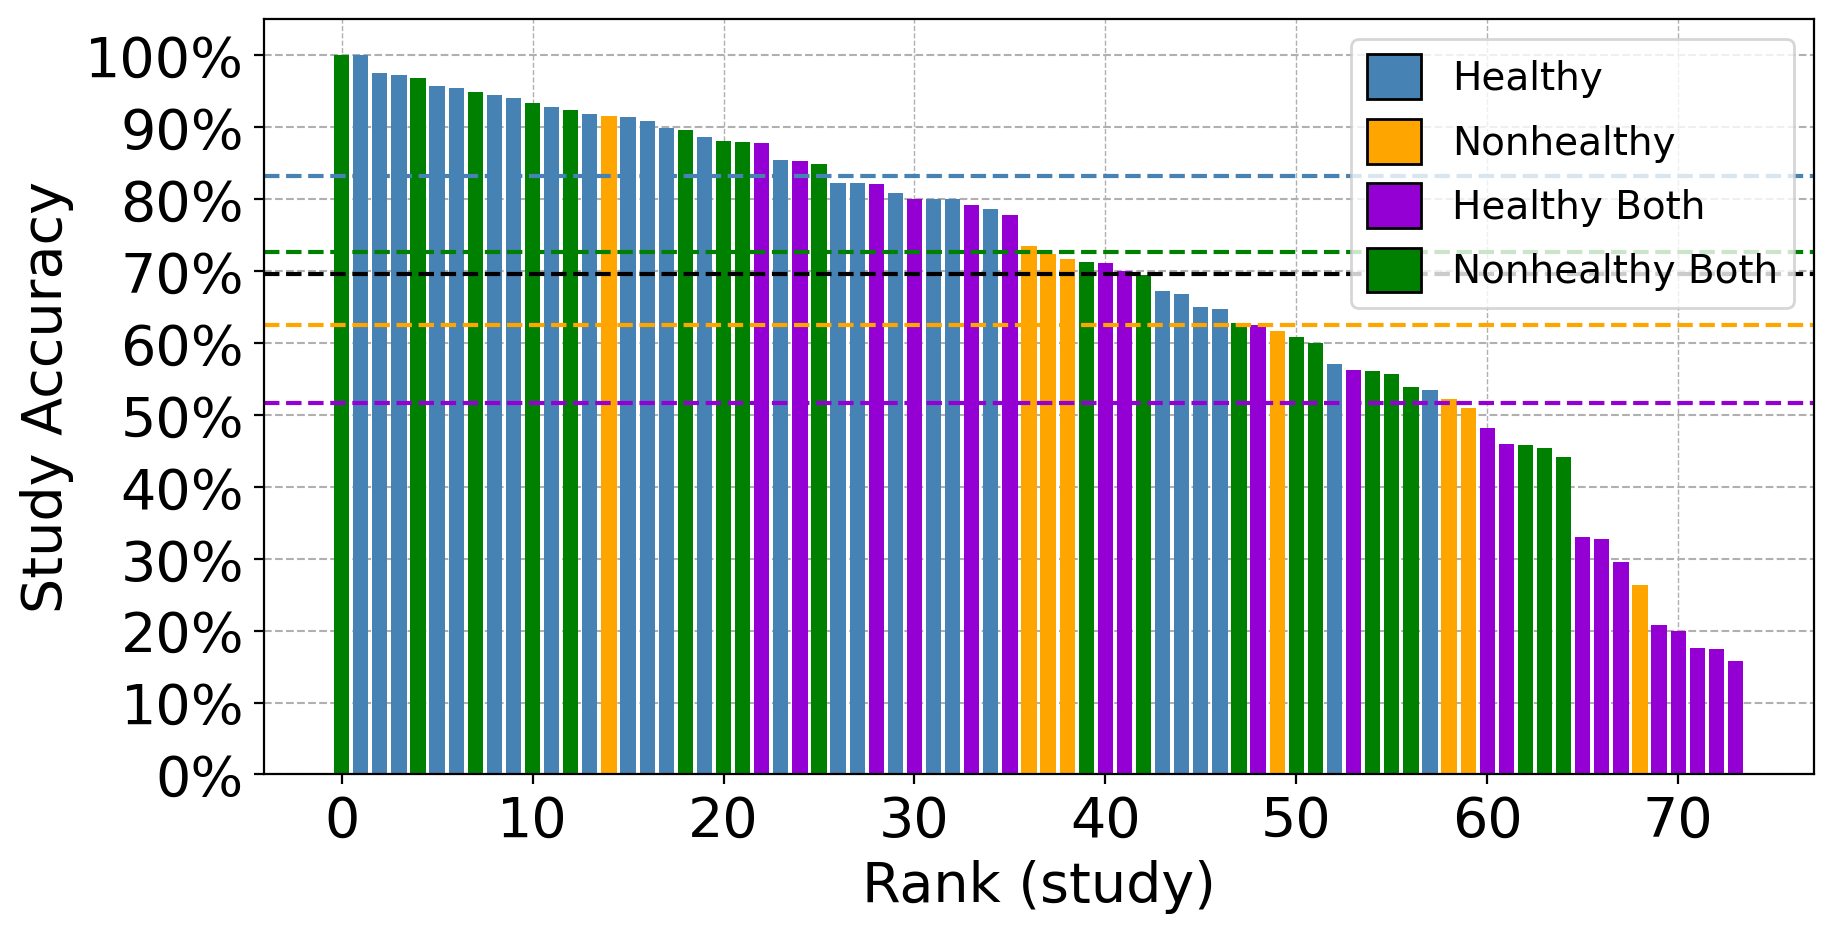

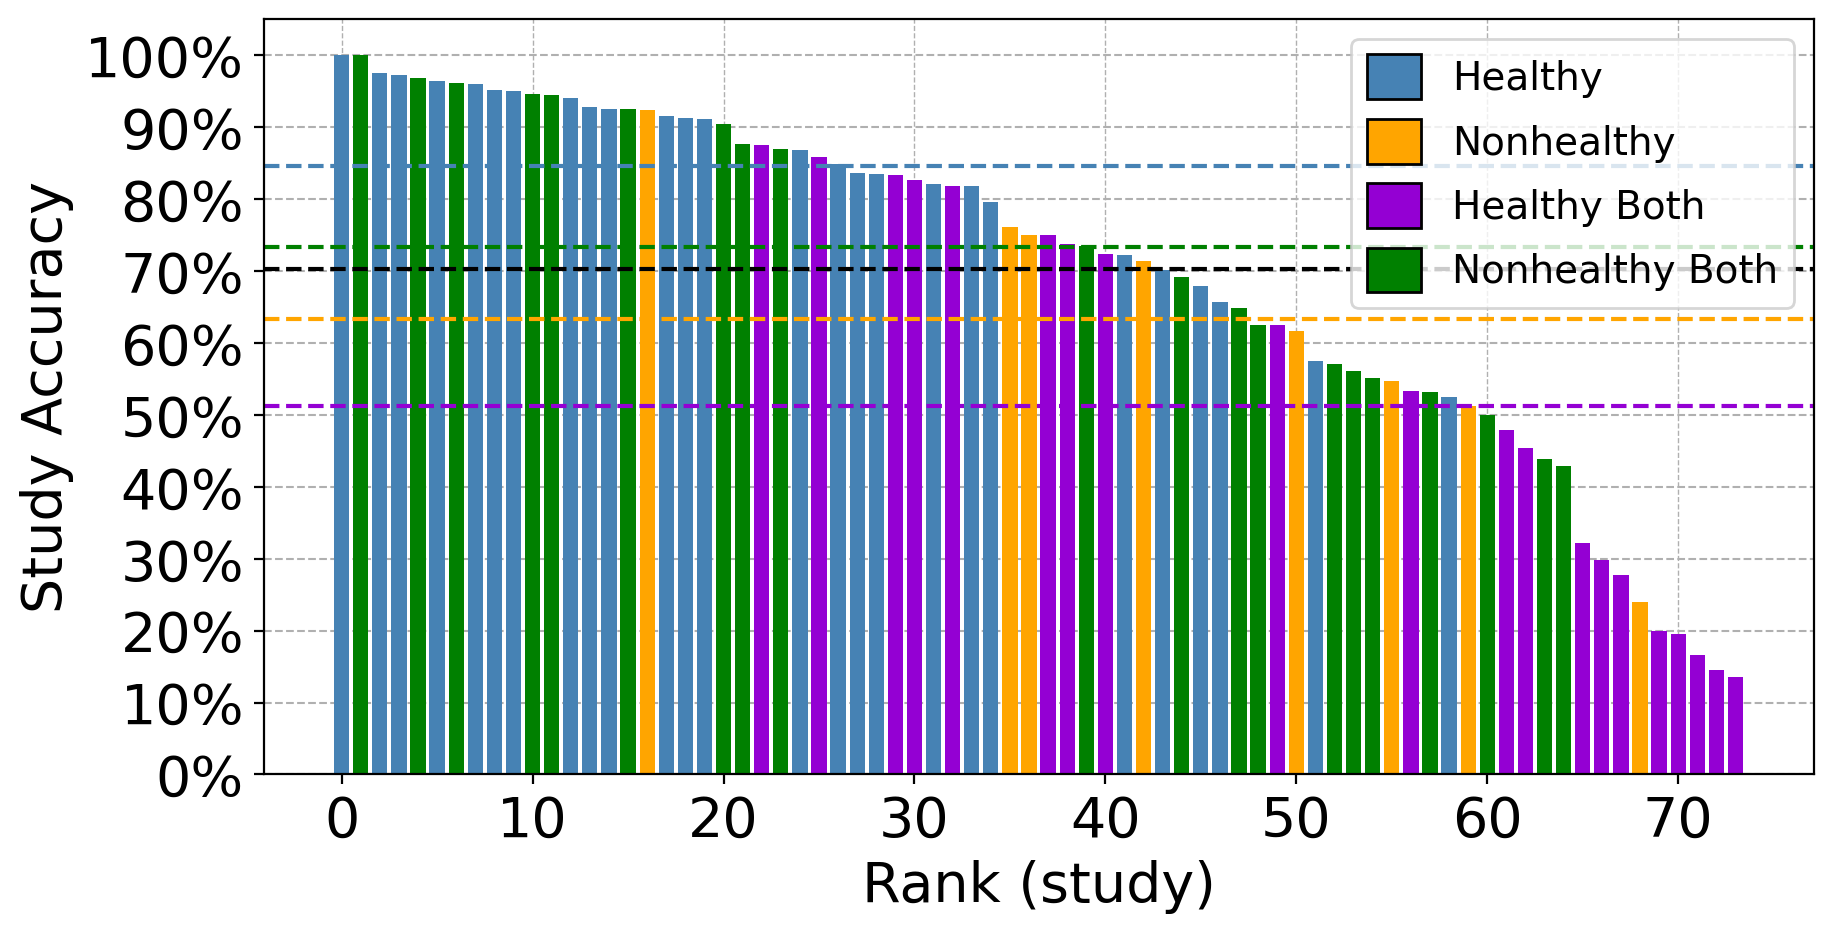

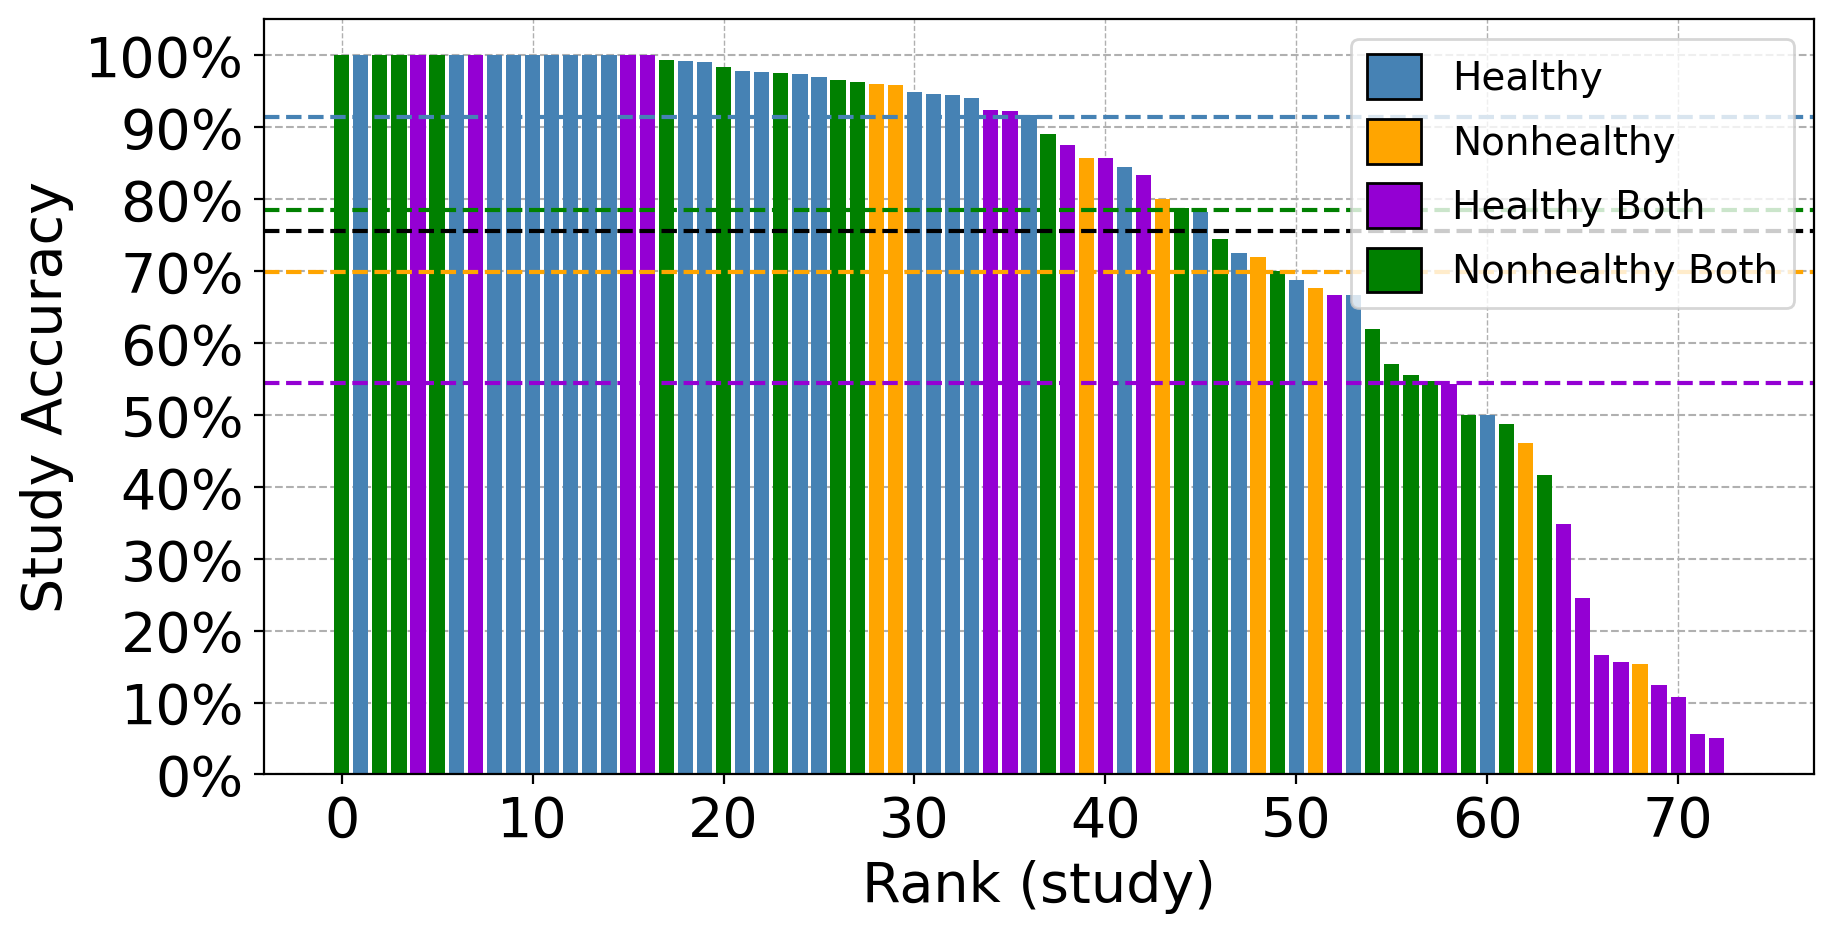

In [6]:
plot_performance_per_study_bar(0, balanced=False)
print()
plot_performance_per_study_bar(0.1, balanced=False)
print()
plot_performance_per_study_bar(1, balanced=False)
print()

In [7]:
# plot_performance_per_study_bar(0, balanced=True)
# plot_performance_per_study_bar(0.1, balanced=True)
# plot_performance_per_study_bar(1, balanced=True)

# Plot scatter performance

In [8]:
def plot_performance_per_study_scatter(cutoff, balanced=True):
    # set constants based on parameters
    scoring_func = balanced_accuracy_score if balanced else accuracy_score
    
    # set names
    yaxis_label = "Study Balanced Accuracy" if balanced else "Study Accuracy"
    filename = f"accuracy_per_study_scatter_cutoff={cutoff}.svg"
    filename = ("balanced_" if balanced else "") + filename
    
    # get study scores
    GMHI2_study_scores = get_study_scores(GMHI2_scores_ISV, y, scoring_func, cutoff=cutoff)
    
    GMHI2_study_scores = GMHI2_study_scores.sort_values("size")
    
    
    # set colors based on phenotypes in studies
#     colors = np.array([
#         healthy_color if float(y.loc[s].mean()) == 1 else \
#         nonhealthy_color if float(y.loc[s].mean()) == 0 else both_color 
#         for s in df.index
#     ])
    colors = np.array([
        nonhealthy_both_color if s.endswith("nonhealthy_both") else \
        healthy_both_color if s.endswith("healthy_both") else \
        healthy_color if float(y.loc[s].mean()) == 1 else \
        nonhealthy_color if float(y.loc[s].mean()) == 0 else "bruh_error" 
        for s in GMHI2_study_scores.index
    ])
    
    # plot stuff
    plt.figure(figsize=(10, 5), dpi=dpi)
    
    ax = plt.gca()
    
    plt.scatter(GMHI2_study_scores["size"], GMHI2_study_scores["score"], c=colors)
    
    ax.tick_params(axis="both", labelsize=20)

    ax.set_ylabel(yaxis_label, fontsize=20)
    ax.set_xlabel("Study Sample Size", fontsize=20)
#     plt.yticks(np.arange(0, 1.1, 0.1))

    ax.set_axisbelow(True)

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    handles = [
        Patch(facecolor=healthy_color, edgecolor="k", label="Healthy", alpha=1),
        Patch(facecolor=nonhealthy_color, edgecolor="k", label="Nonhealthy", alpha=1),
        Patch(facecolor=healthy_both_color, edgecolor="k", label="Healthy Both", alpha=1),
        Patch(facecolor=nonhealthy_both_color, edgecolor="k", label="Nonhealthy Both", alpha=1),
    ]

    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend(handles=handles, prop={'size': 14}, loc=0, handlelength=1.4, handleheight=1.4)
    plt.savefig(os.path.join(config.FIGURE_DIR, filename), bbox_inches='tight')

In [9]:
# plot_performance_per_study_scatter(0, balanced=True)
# plot_performance_per_study_scatter(0.1, balanced=True)
# plot_performance_per_study_scatter(1, balanced=True)

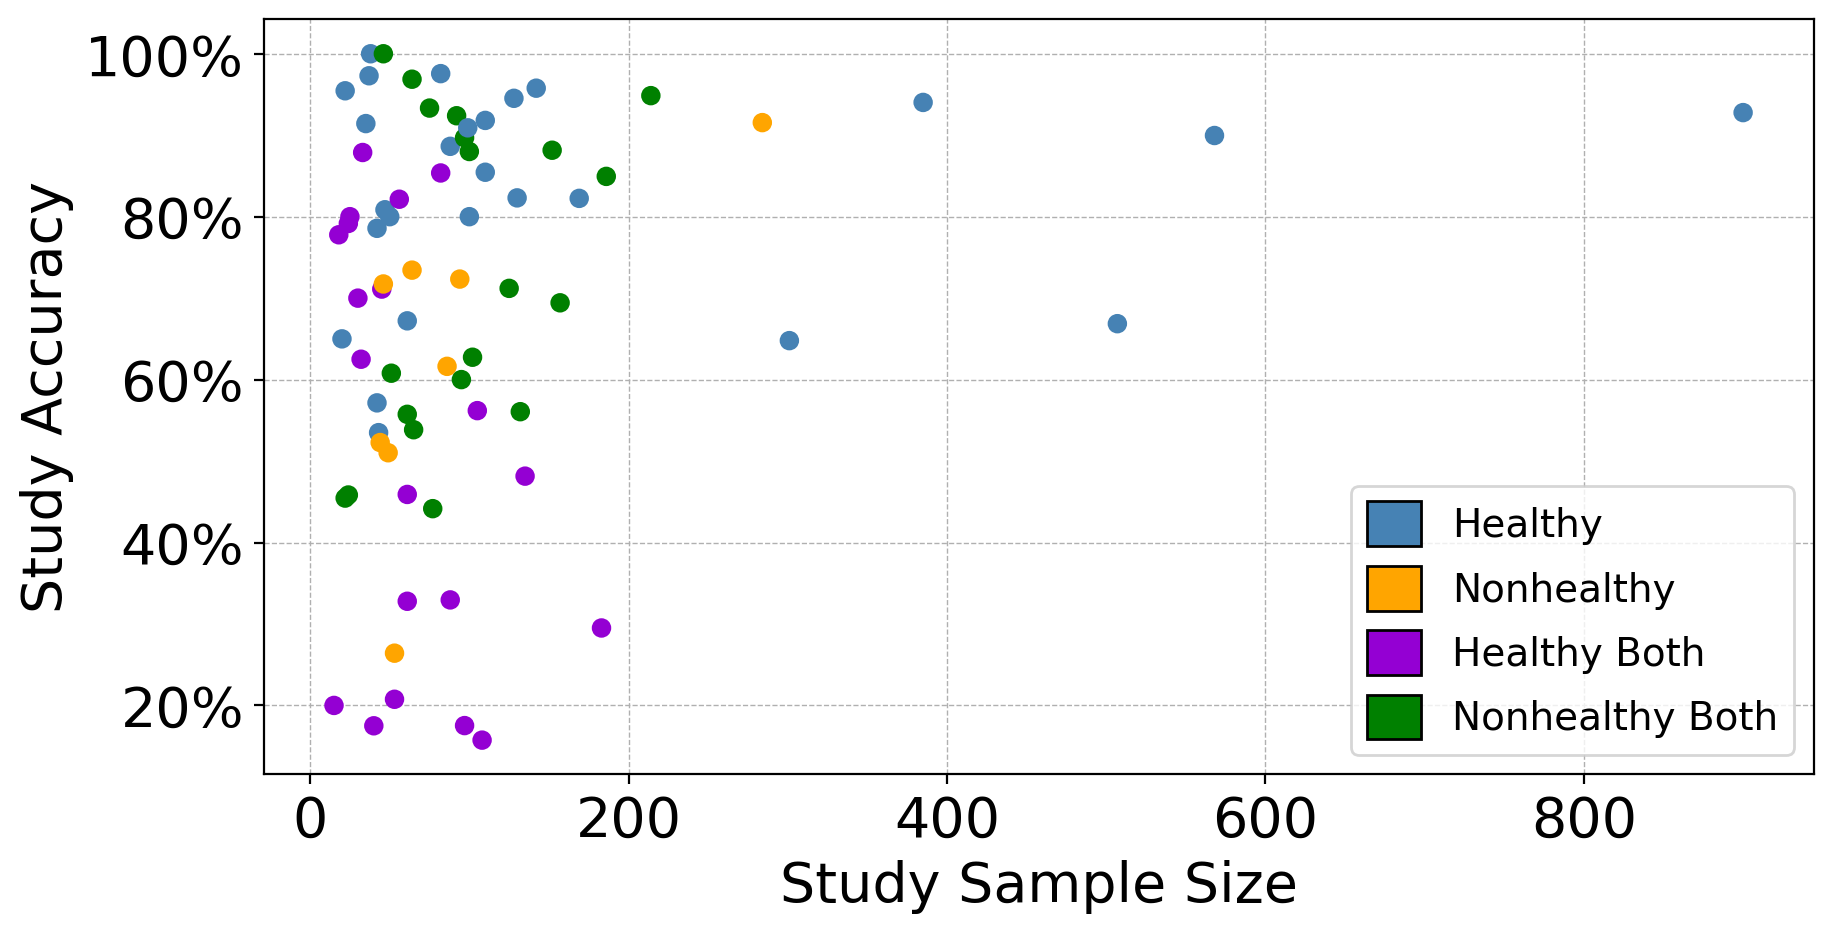

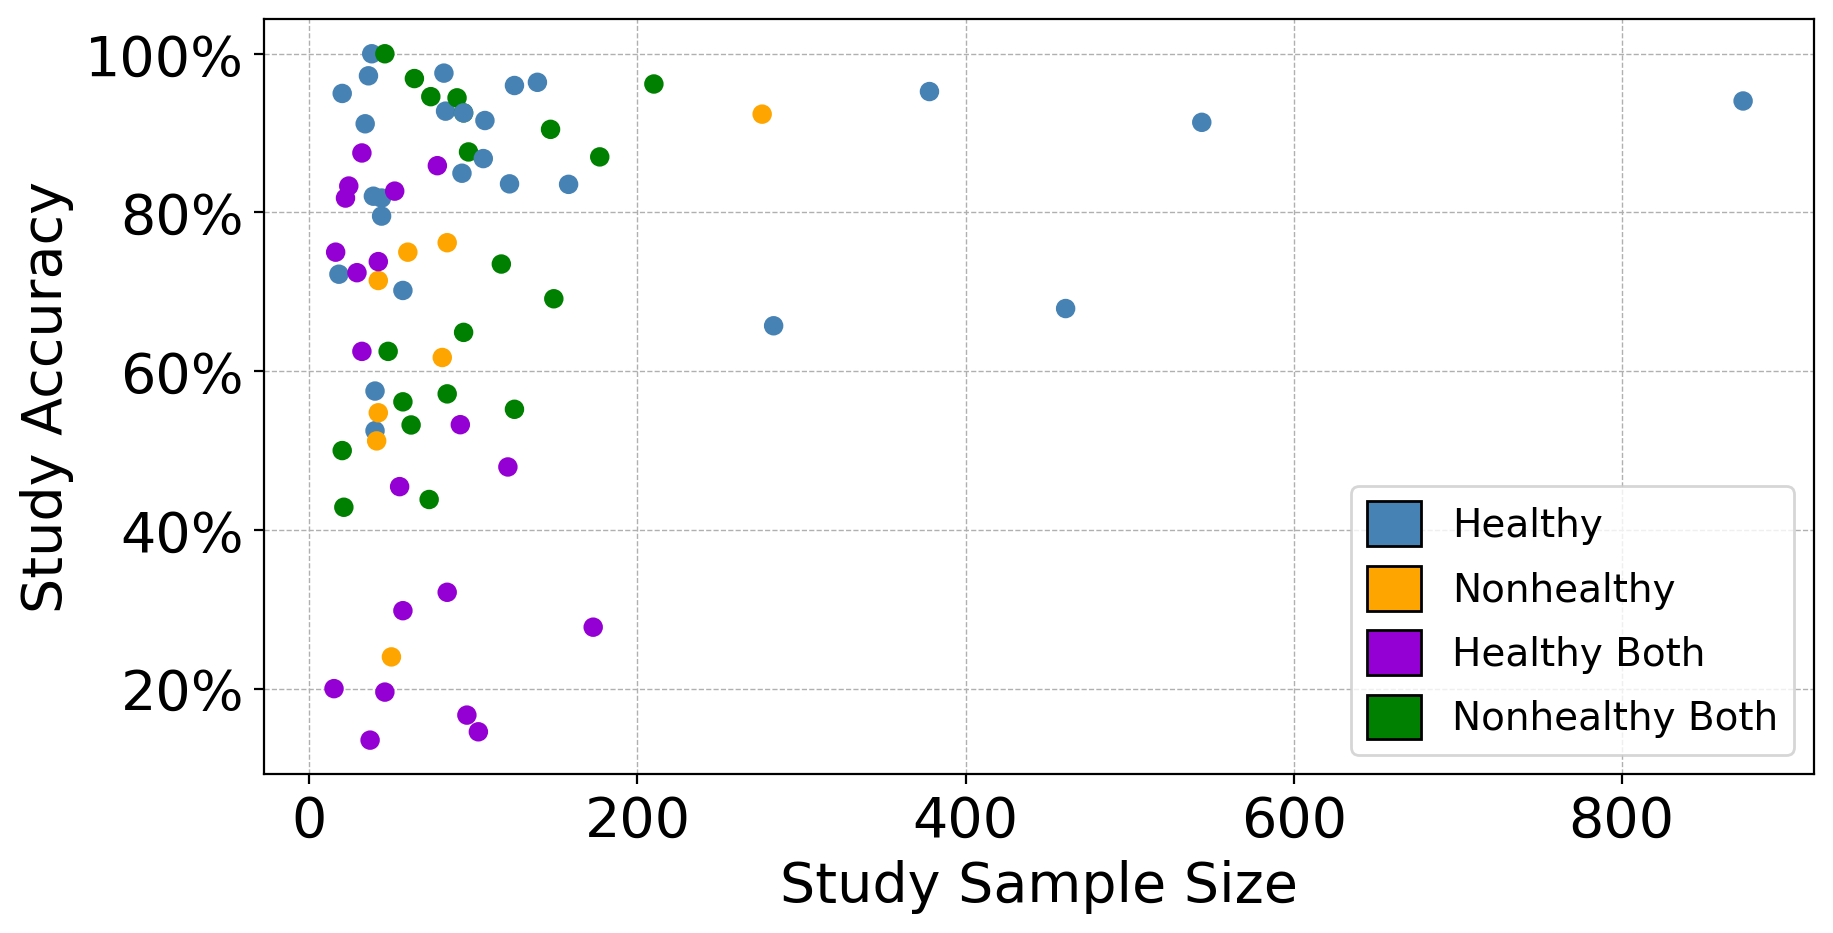

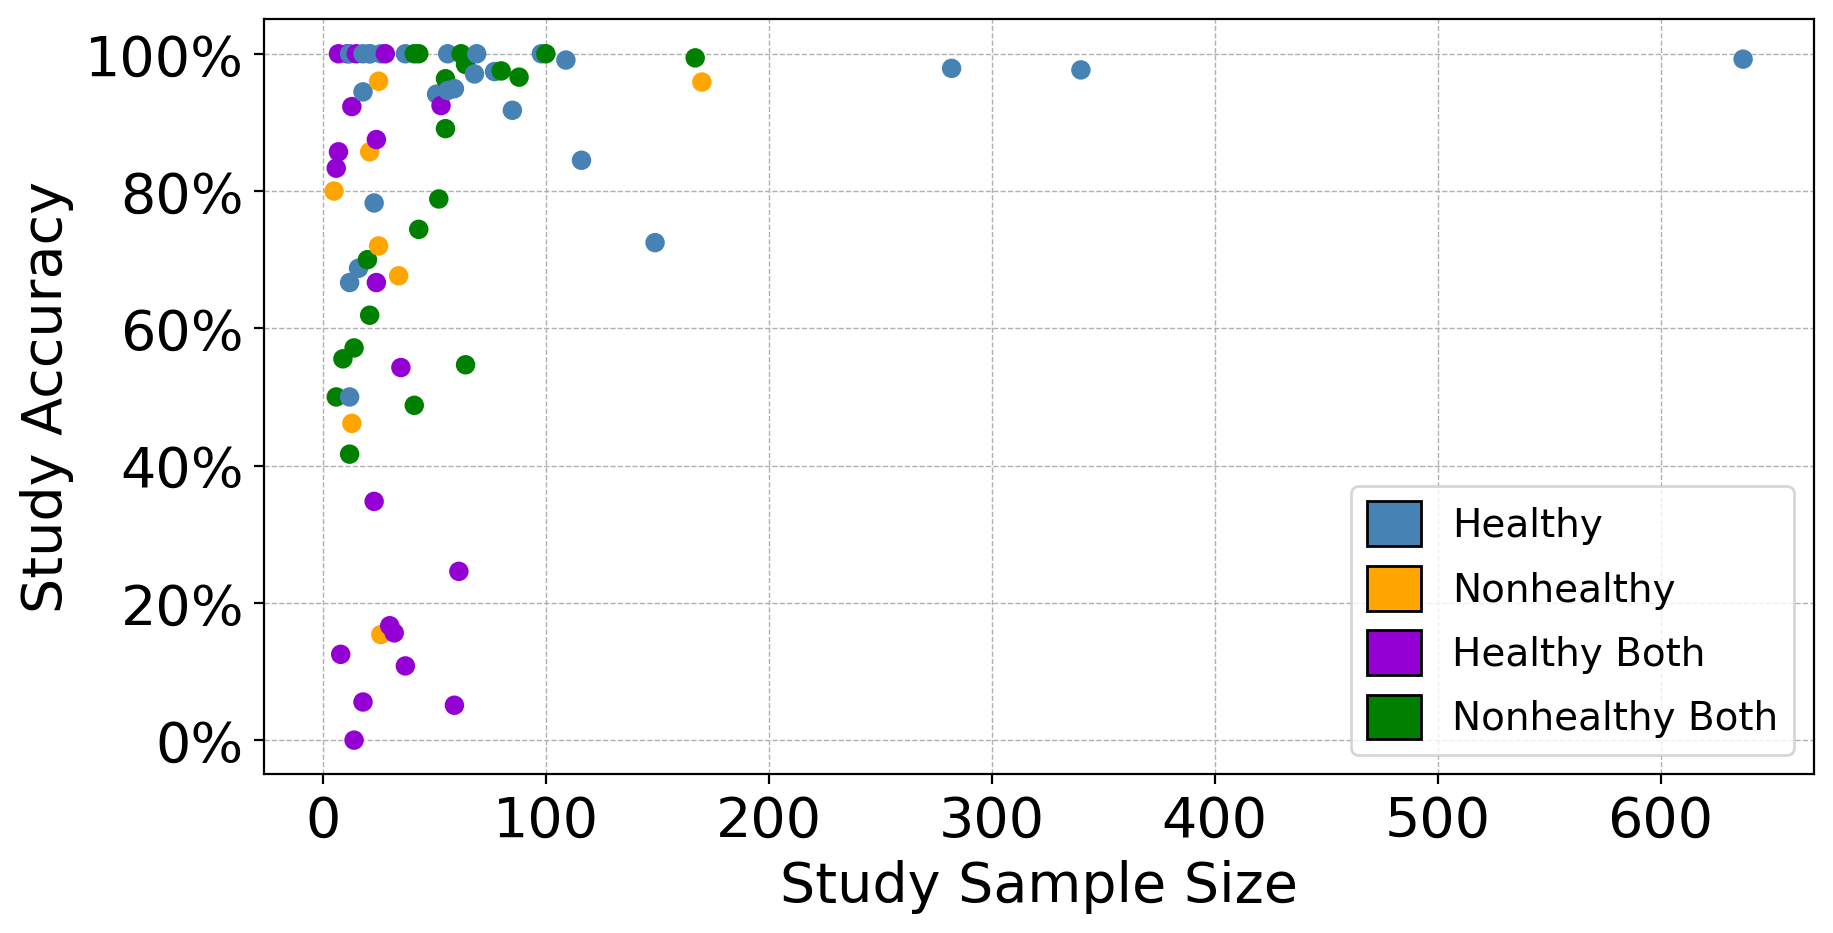

In [10]:
plot_performance_per_study_scatter(0, balanced=False)
plot_performance_per_study_scatter(0.1, balanced=False)
plot_performance_per_study_scatter(1, balanced=False)

In [11]:
GMHI2_study_scores = get_study_scores(GMHI2_scores_ISV, y, balanced_accuracy_score, cutoff=0)
GMHI2_study_scores

,score,size
study,,
GMHI-10,0.650000,20
GMHI-11,0.717391,46
GMHI-13,0.940260,385
GMHI-14,0.668639,507
GMHI-15,0.927778,900
...,...,...
Ventura_2019_nonhealthy_both,0.458333,24
Yang_2020_healthy_both,0.329545,88
Yang_2020_nonhealthy_both,0.923913,92


GMHI-10


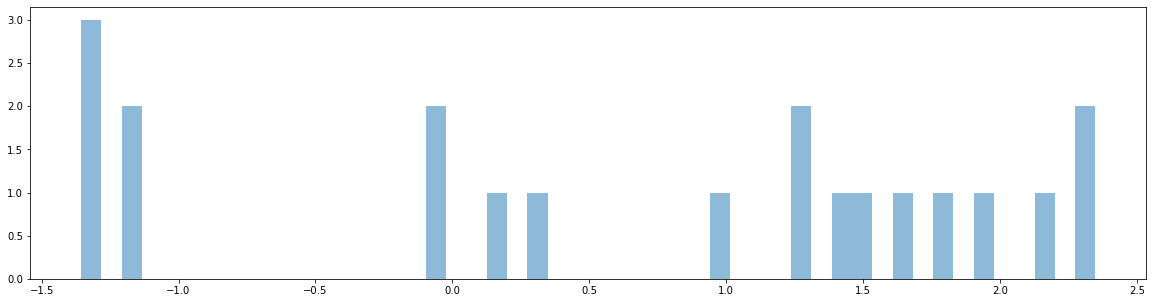

GMHI-11


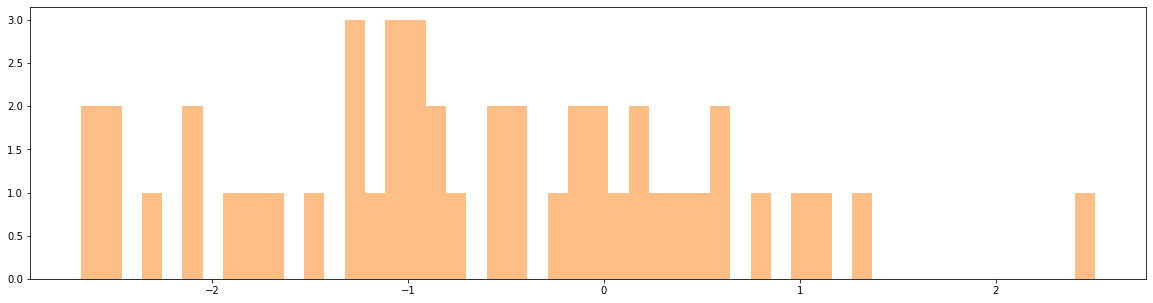

GMHI-13


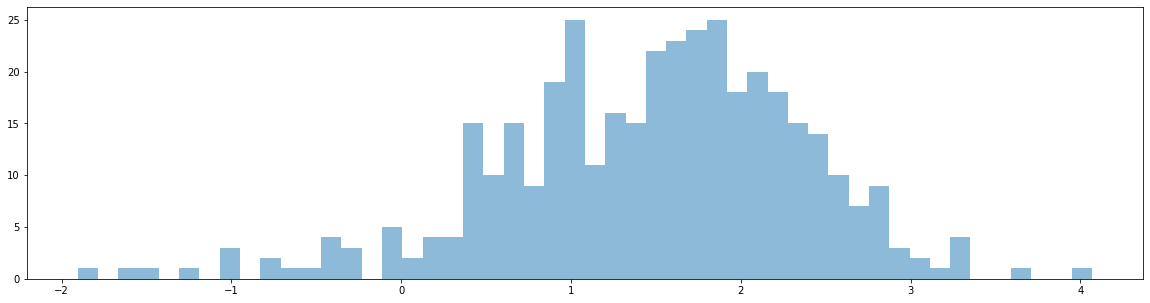

GMHI-14


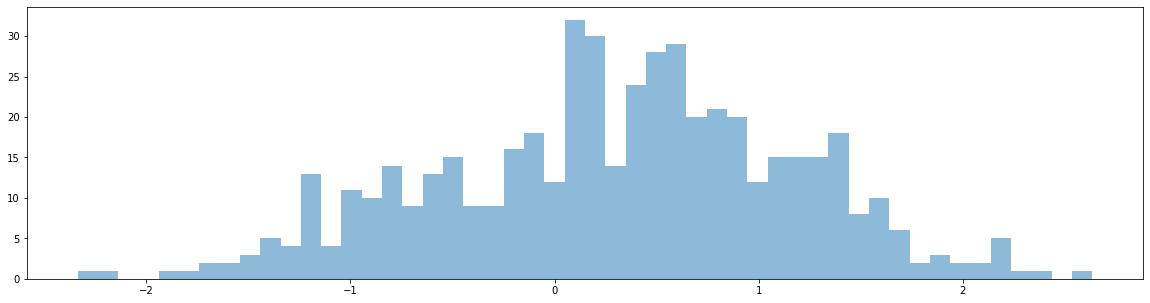

GMHI-15


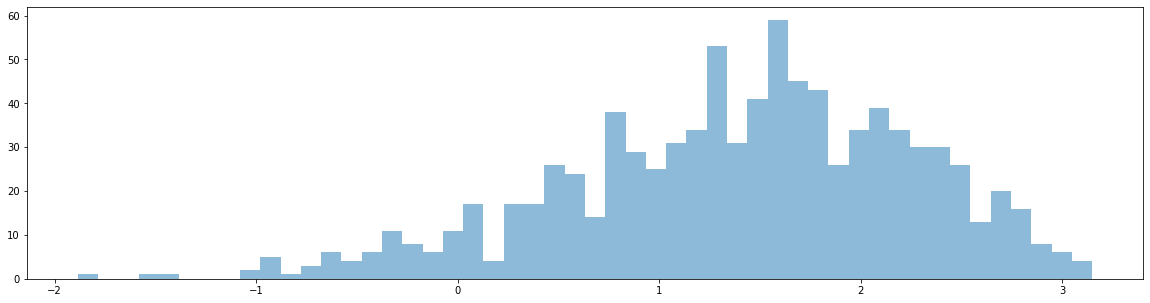

GMHI-17


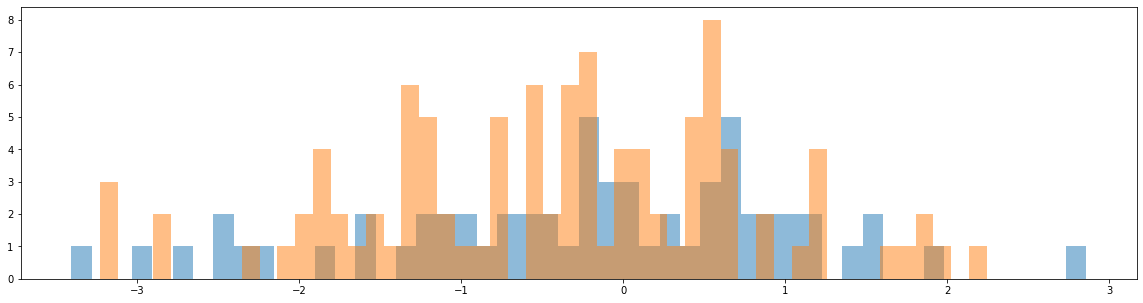

GMHI-2


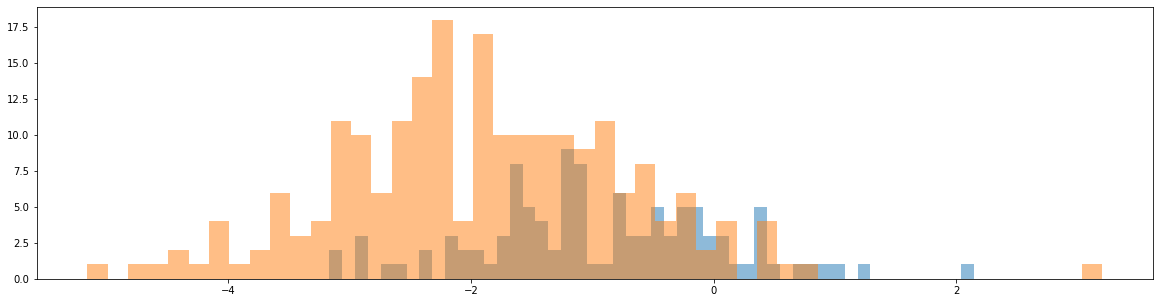

GMHI-23


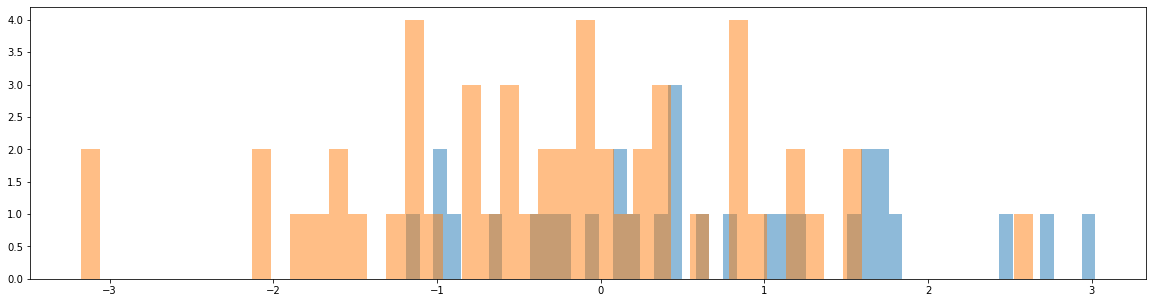

GMHI-24


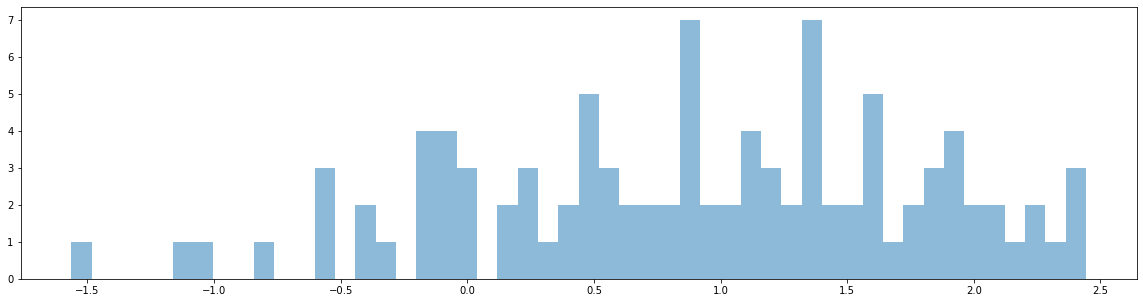

GMHI-26


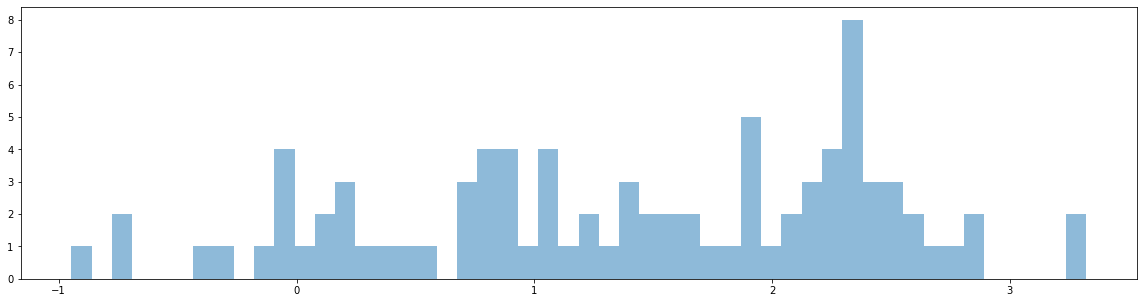

GMHI-27


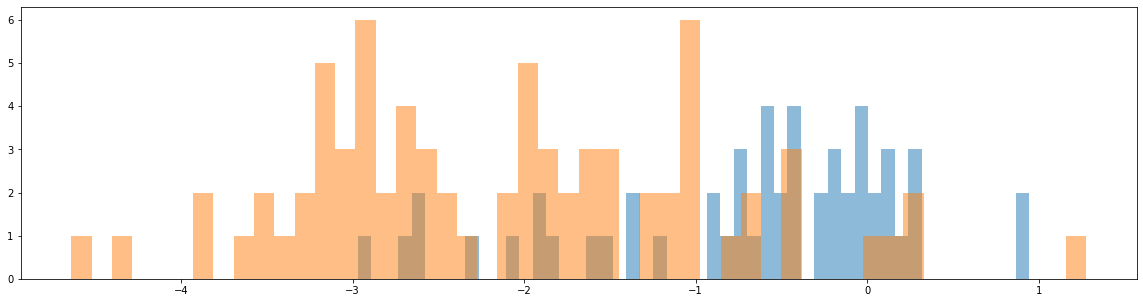

GMHI-28


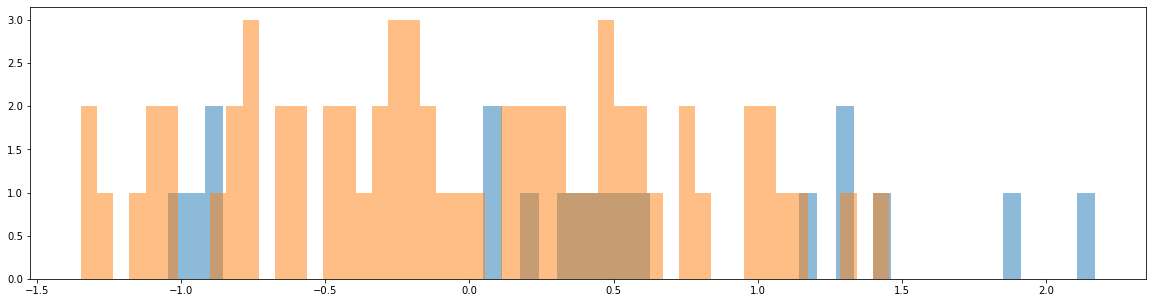

GMHI-3


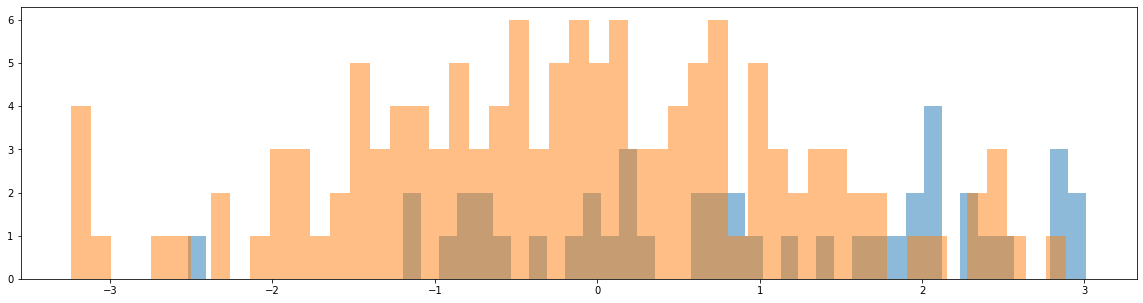

GMHI-31


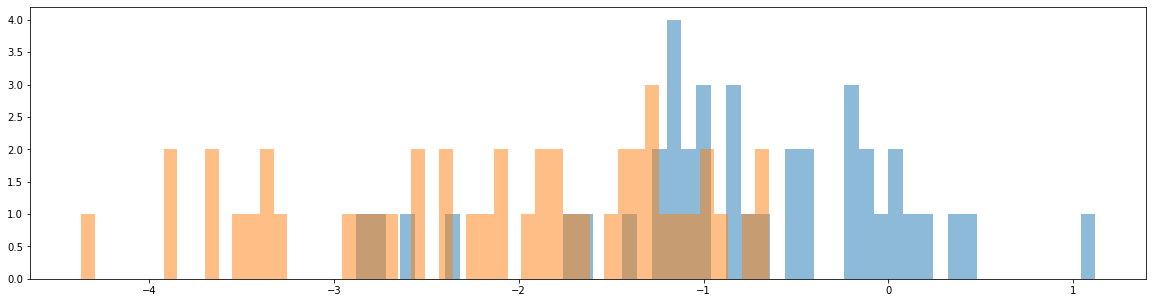

GMHI-32


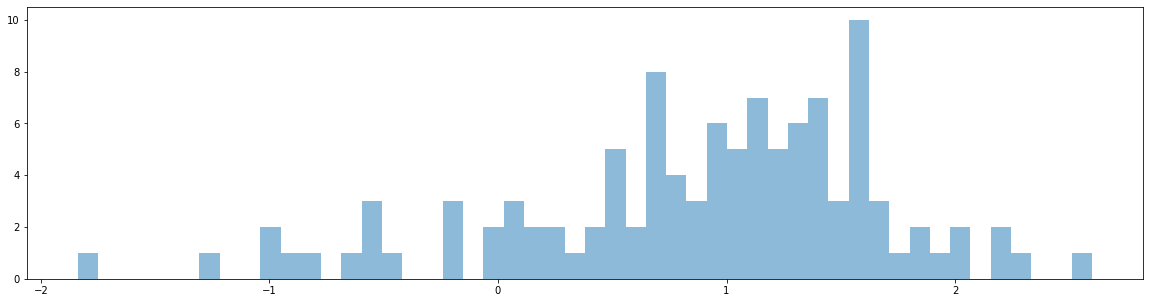

GMHI-33


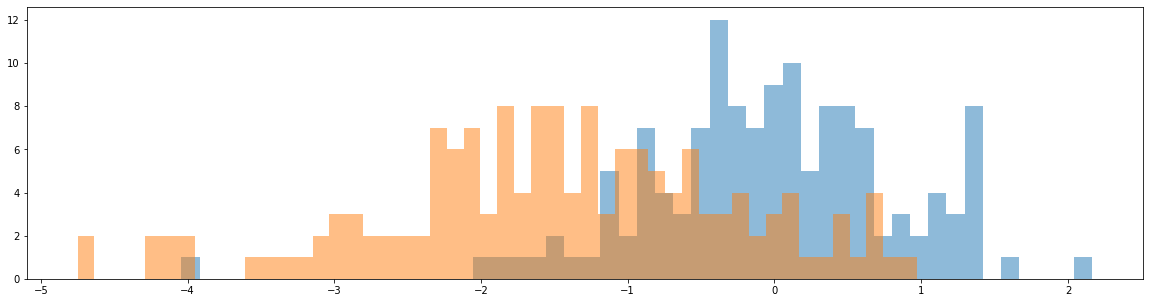

GMHI-4


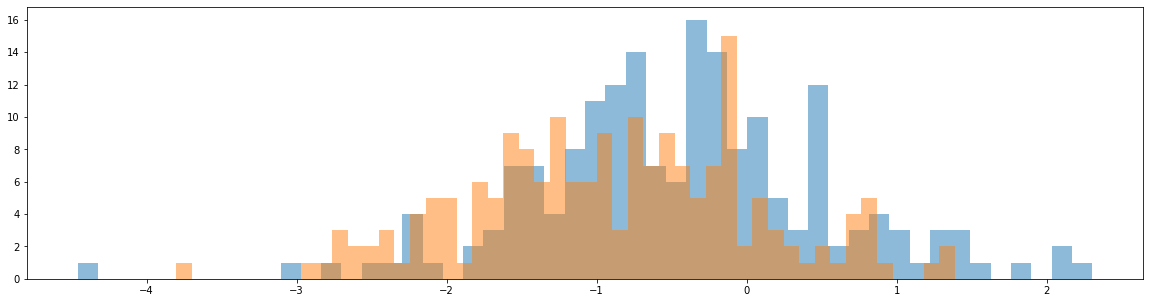

GMHI-5


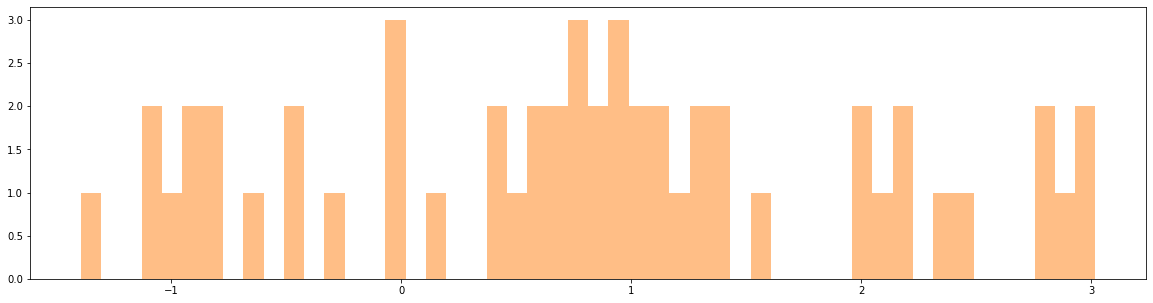

GMHI-9


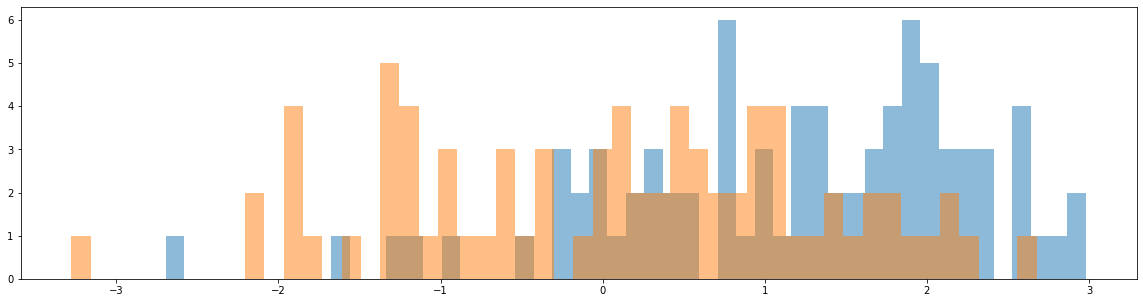

GMHI-V-35


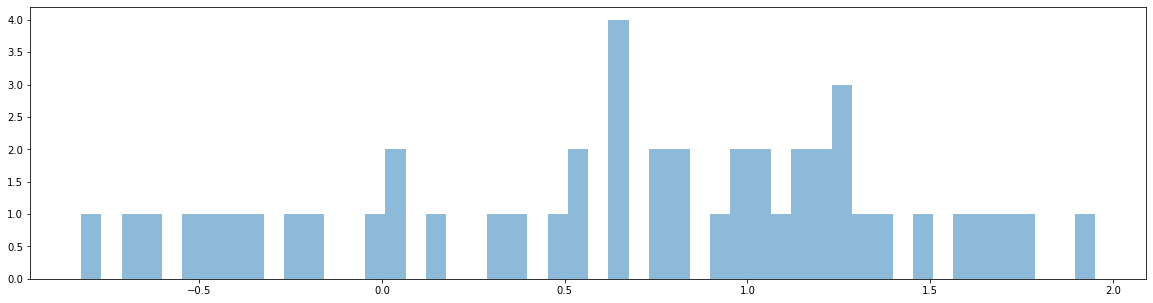

GMHI-V-36


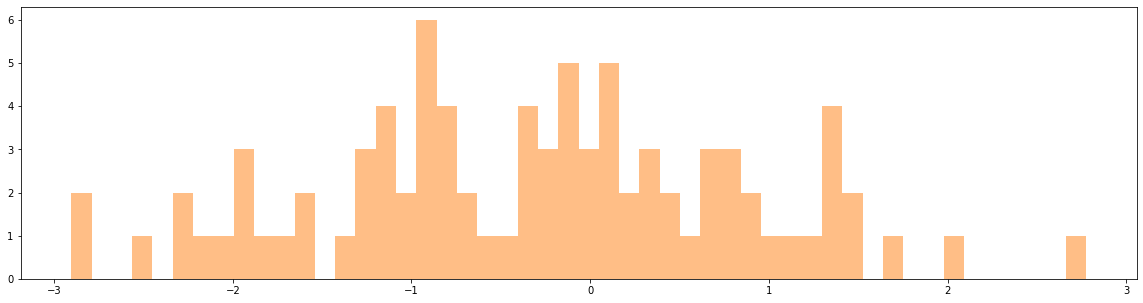

GMHI-V-38


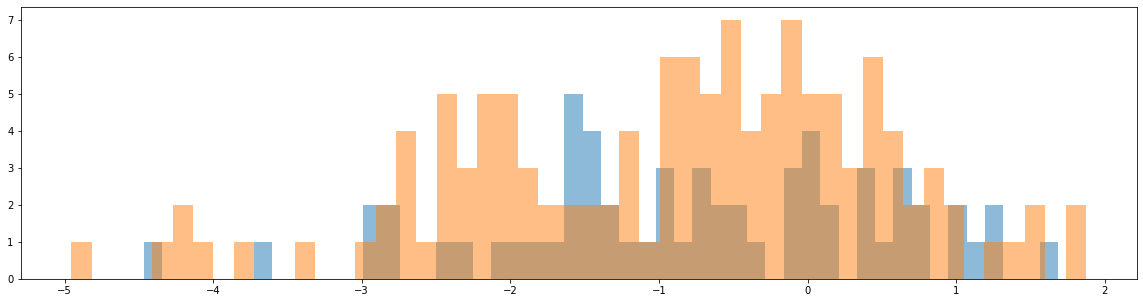

GMHI-V-40


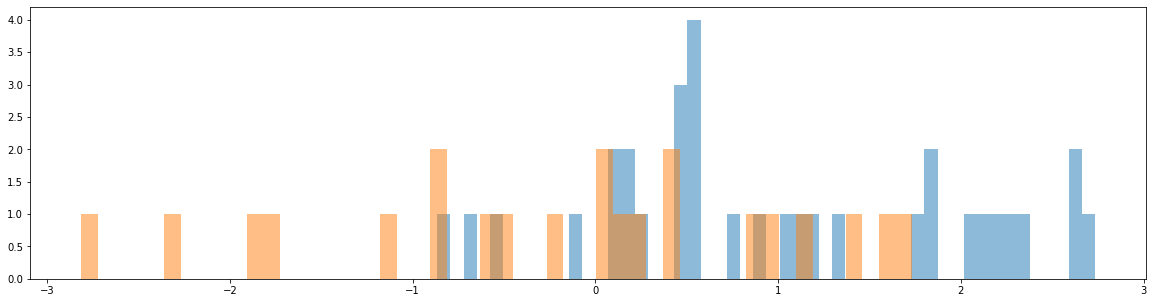

GMHI-V-41


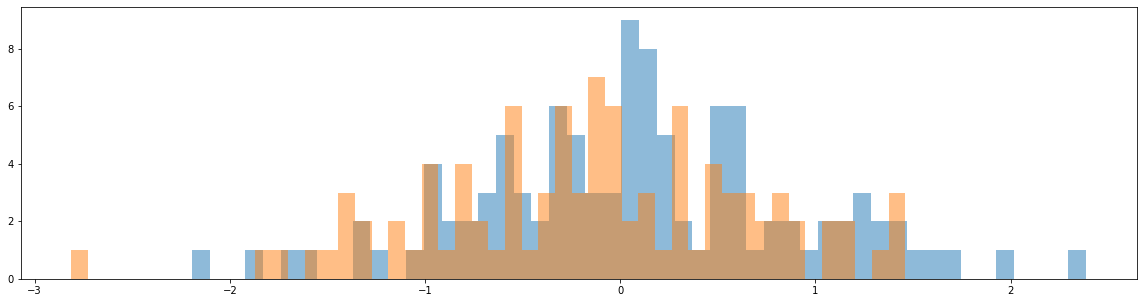

P11


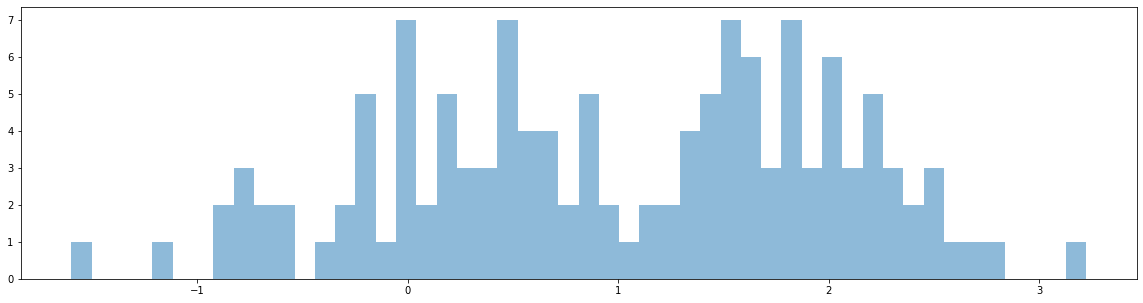

P110


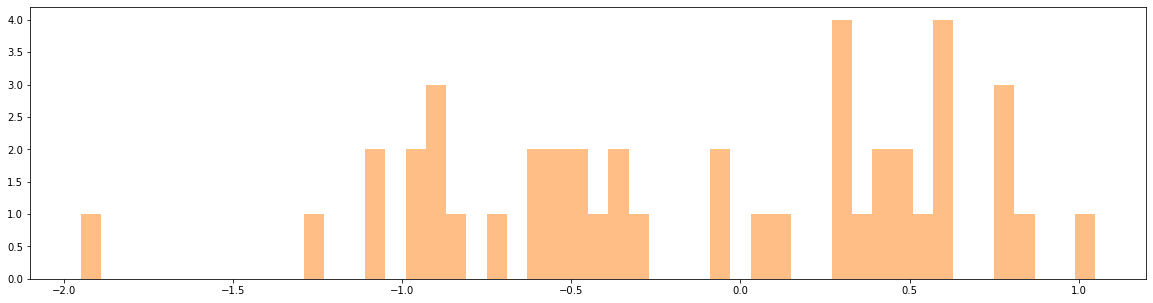

P121


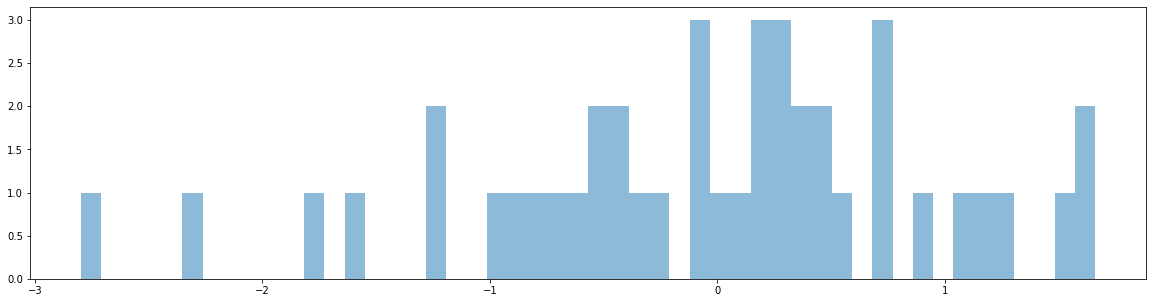

P135


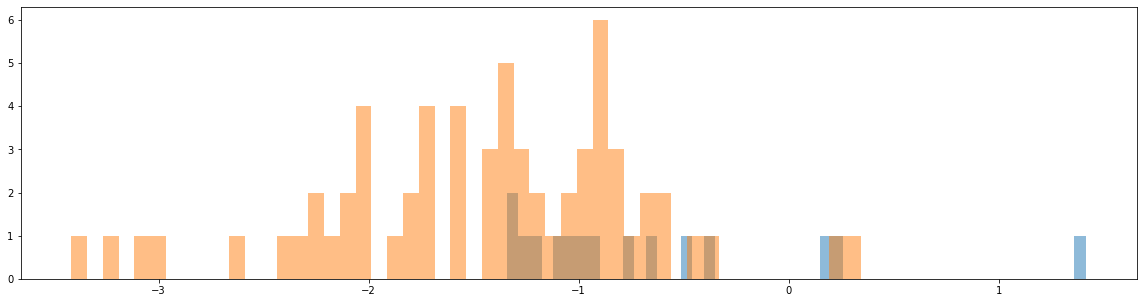

P140


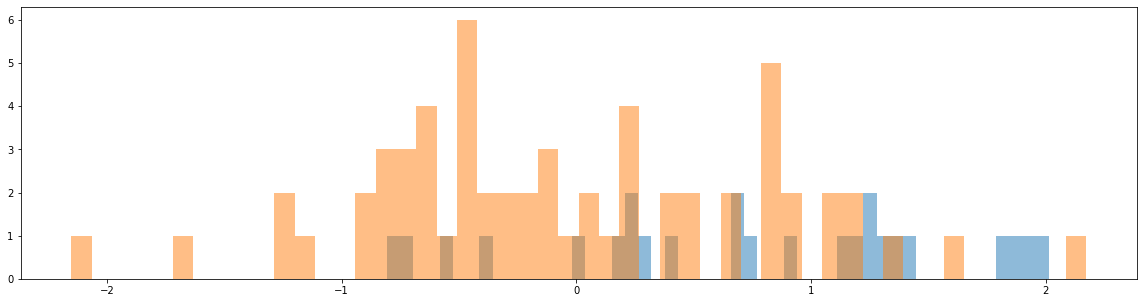

P17


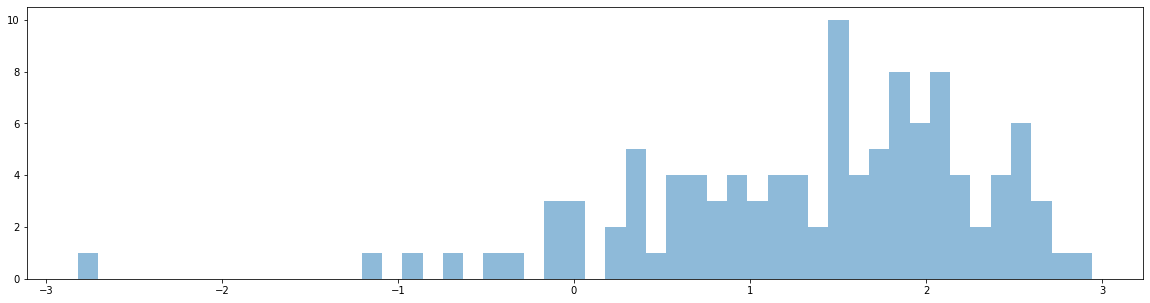

P2


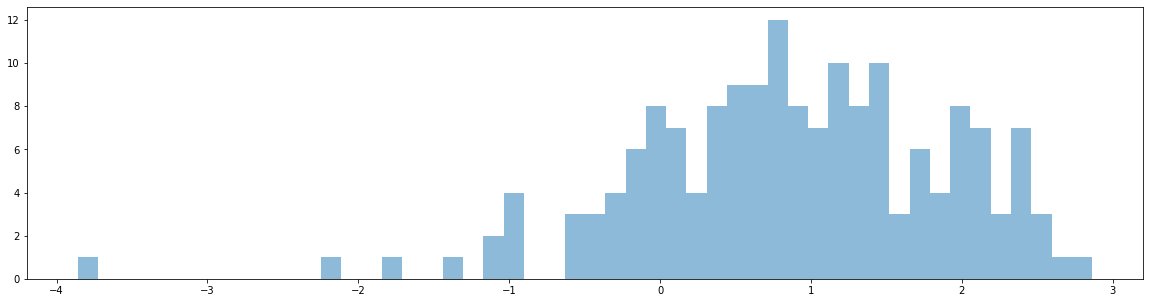

P21


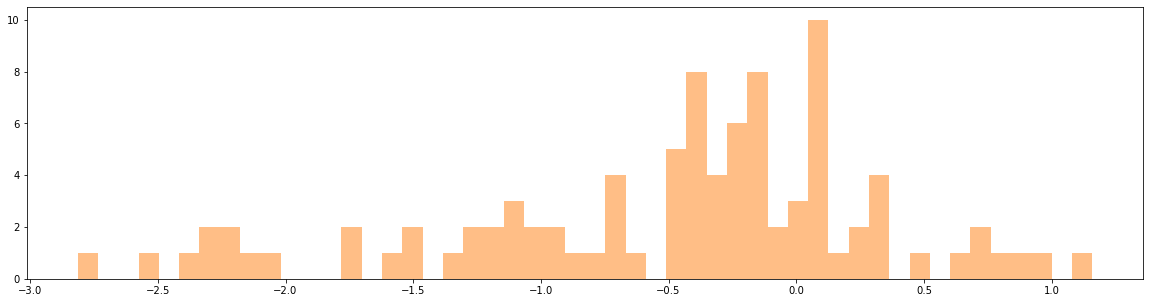

P24


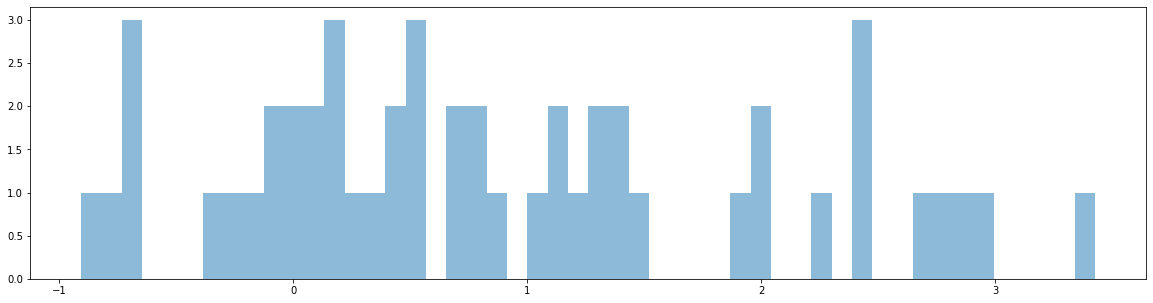

P34


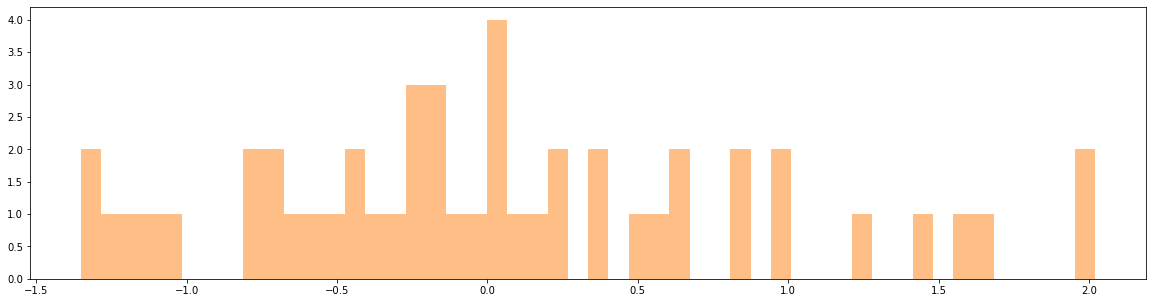

P39


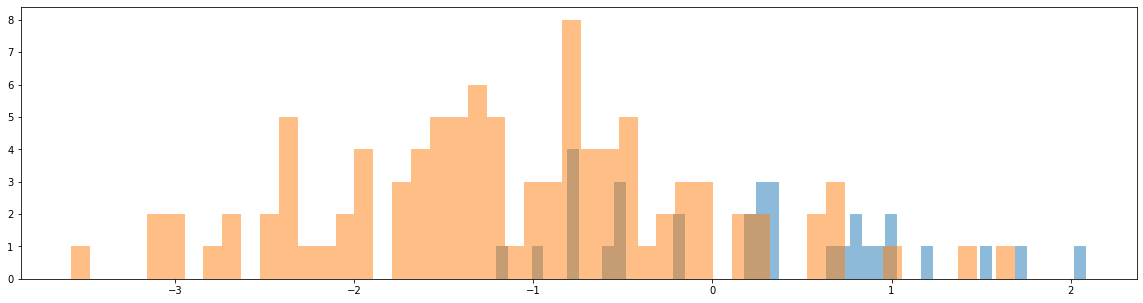

P48


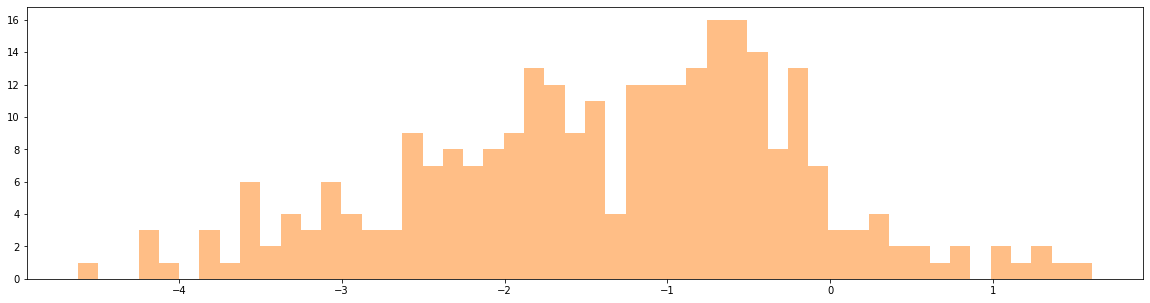

P53


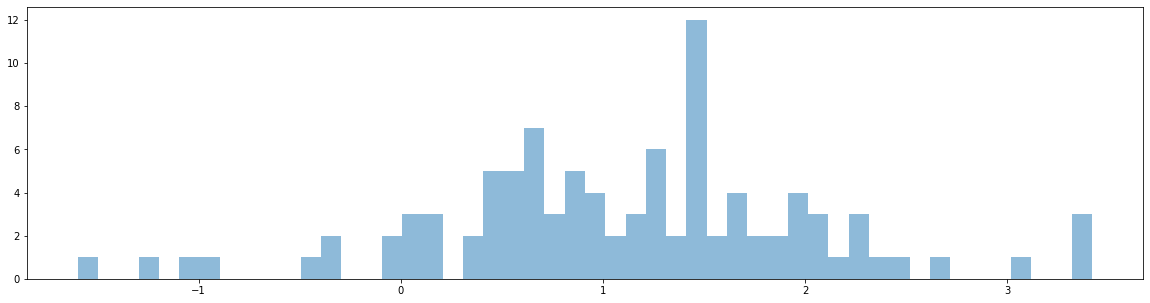

P56


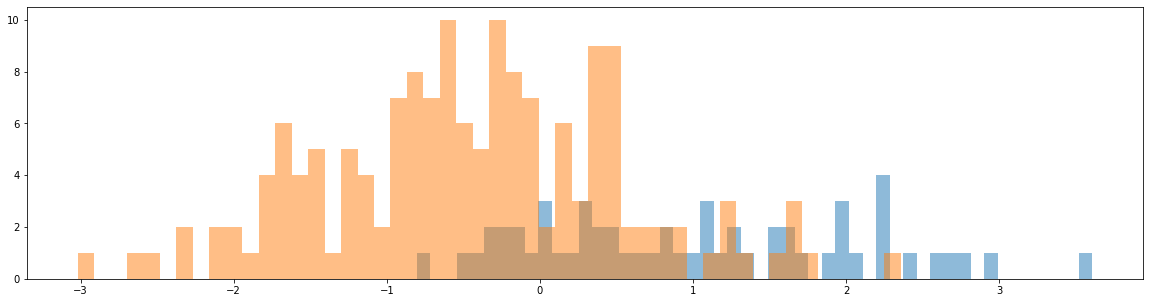

P57


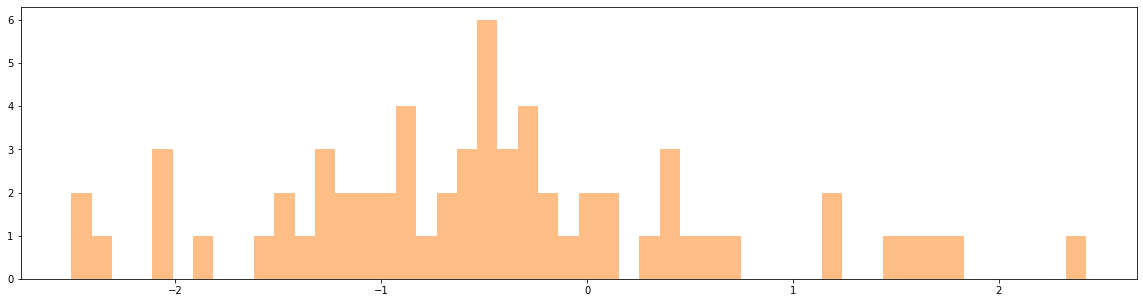

P69


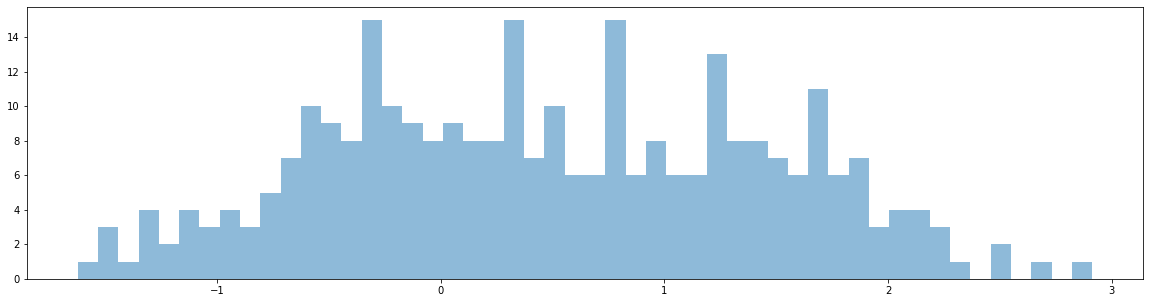

P74


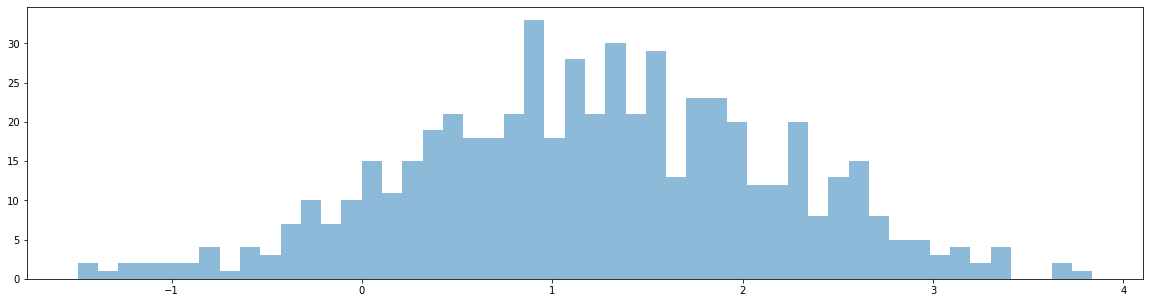

P77


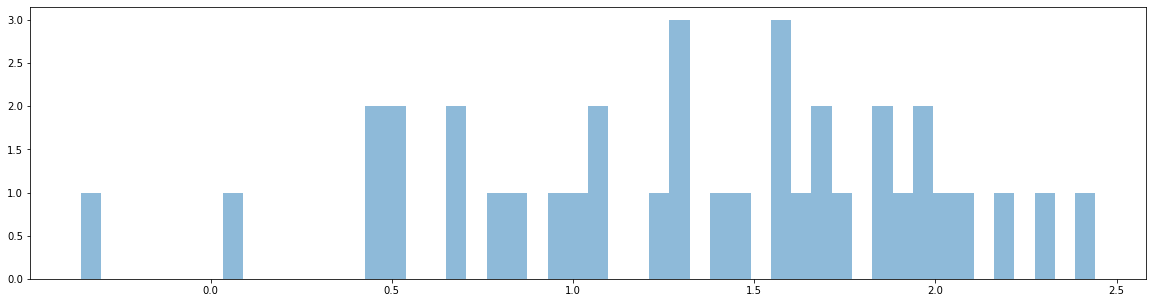

P8


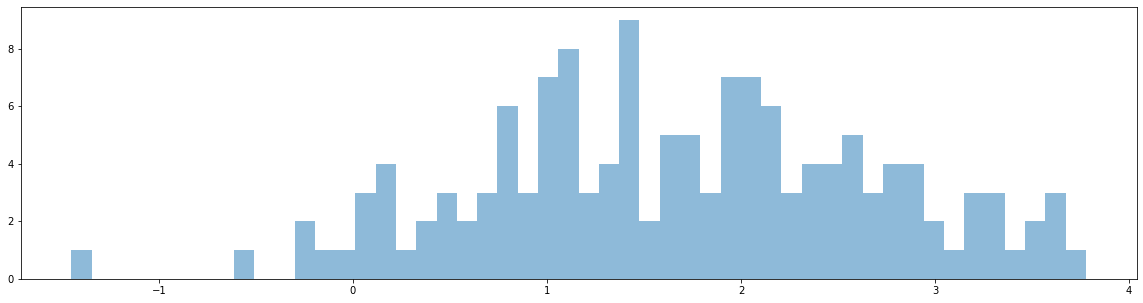

P80


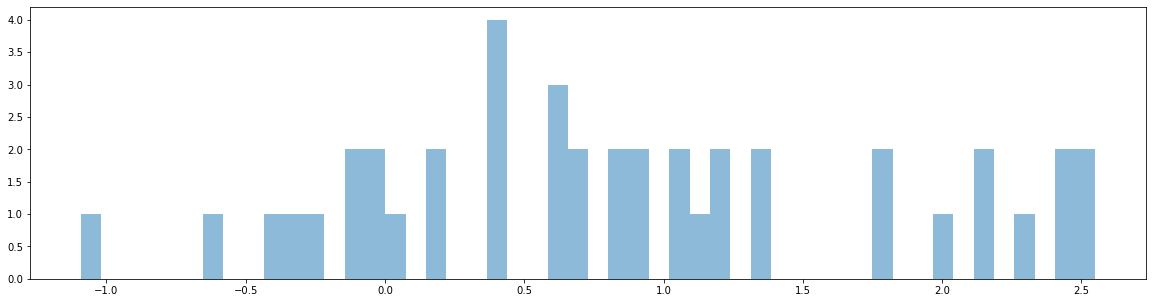

P87


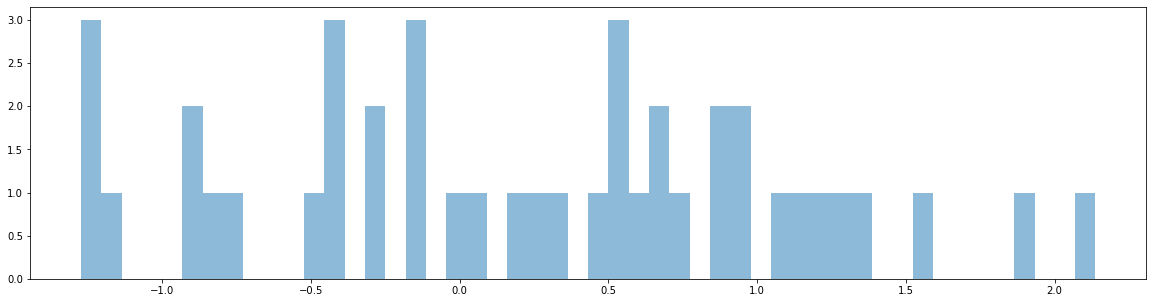

P88


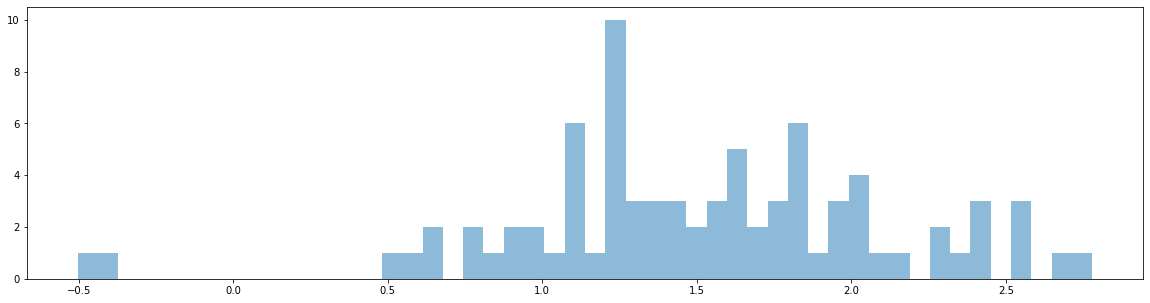

P89


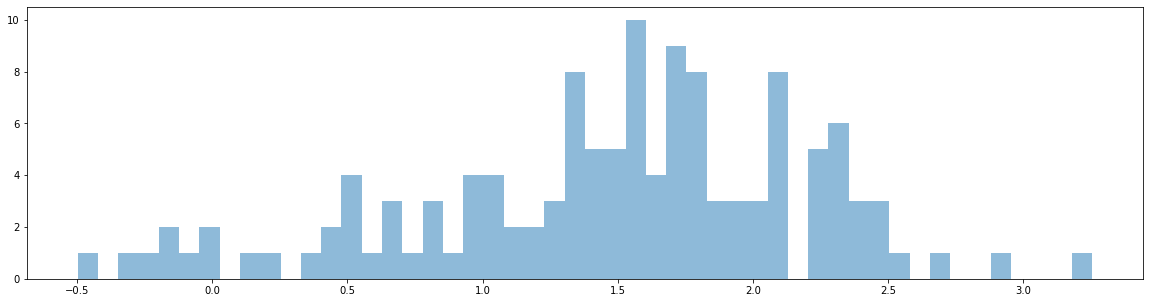

P9


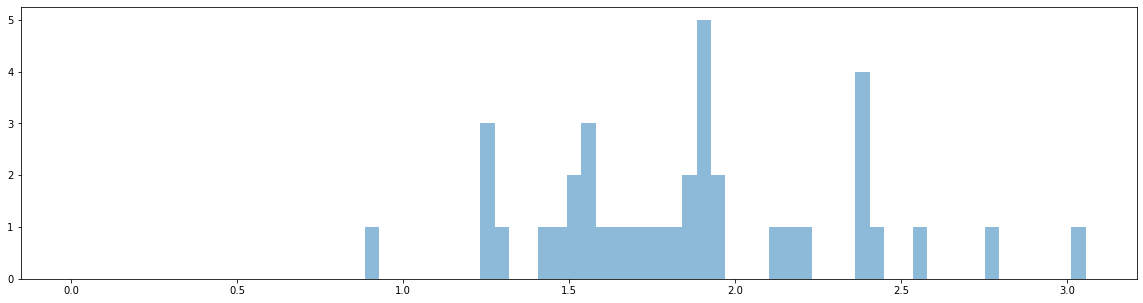

P94


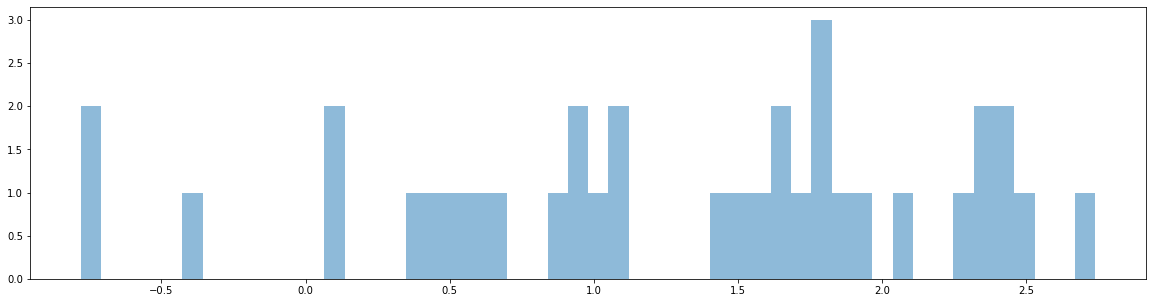

P96


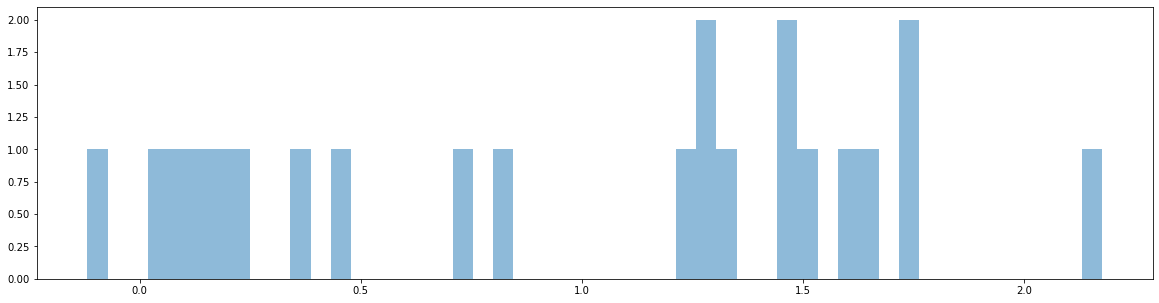

P98


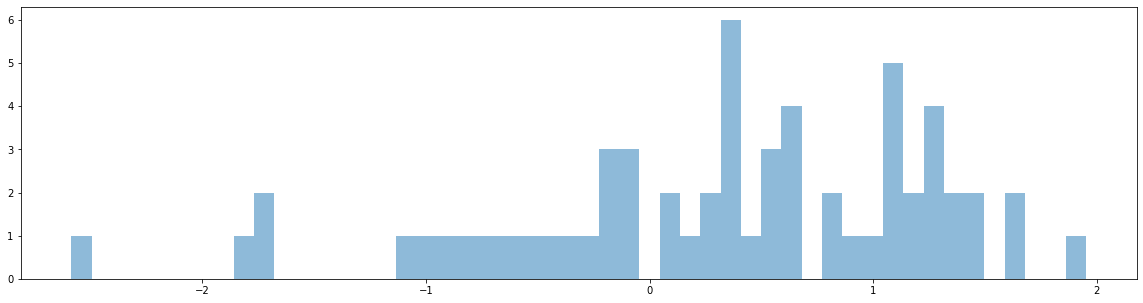

Ventura_2019


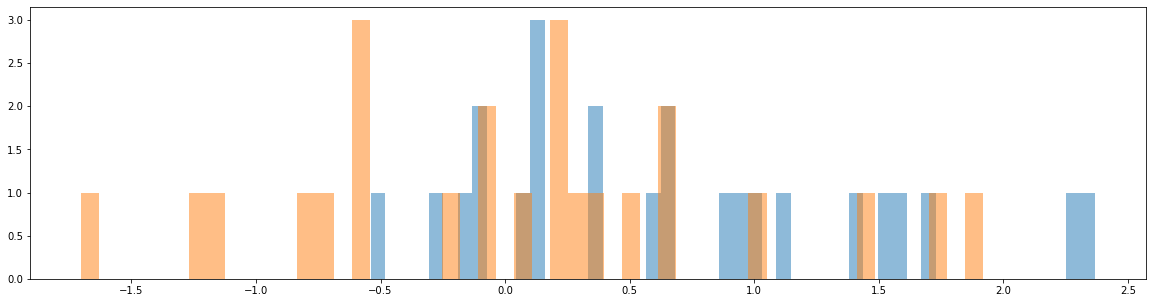

Yang_2021


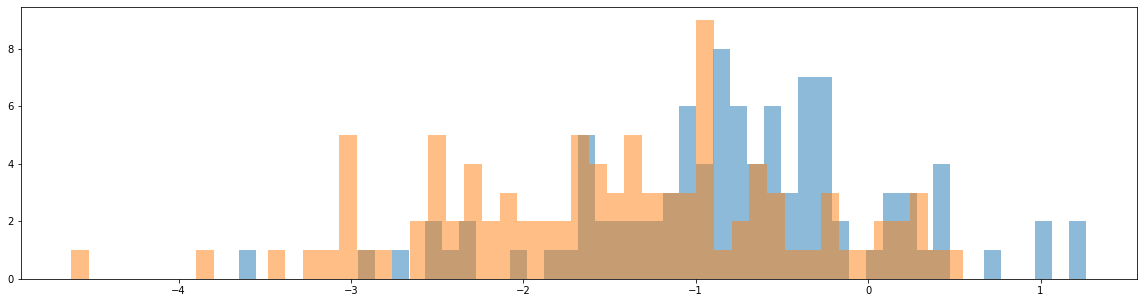

Yang_2020


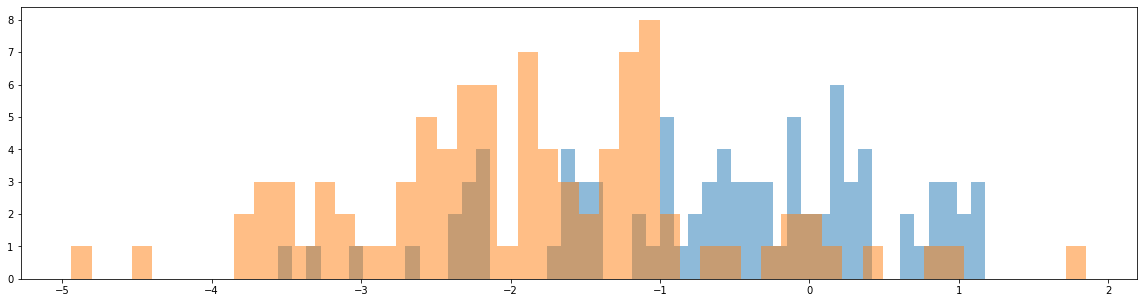

In [12]:
for study in GMHI2_scores_ISV.index.get_level_values(0).unique():
    print(study)

    plt.figure(figsize=(20, 5))

    plt.hist(GMHI2_scores_ISV.loc[study][y.loc[study].values], bins=50, alpha=0.5)
    plt.hist(GMHI2_scores_ISV.loc[study][~y.loc[study].values], bins=50, alpha=0.5)
    
    plt.show()